# Analyzing Startup Success: A Multiple Linear Regression Approach Using the 50_Startups Dataset

![50 startups](https://raw.githubusercontent.com/Ebimsv/Machine_Learning_Course/refs/heads/main/pics/50_startups.png)

## Imports

In [46]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import missingno as msno  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  

## Load the dataset 

In [60]:
df = pd.read_csv('../Data/Regression/50_Startups.csv')  
df.head()  

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,166597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## Preprocessing

### 1. Check and Handle Missing Values
Before proceeding with modeling, it's important to identify and handle any missing values in the dataset.   
This step includes printing the count of missing values per column and visualizing them using a matrix plot to understand their distribution.

Missing Values in Each Column:
 R&D Spend          0
Administration     2
Marketing Spend    1
State              0
Profit             0
dtype: int64


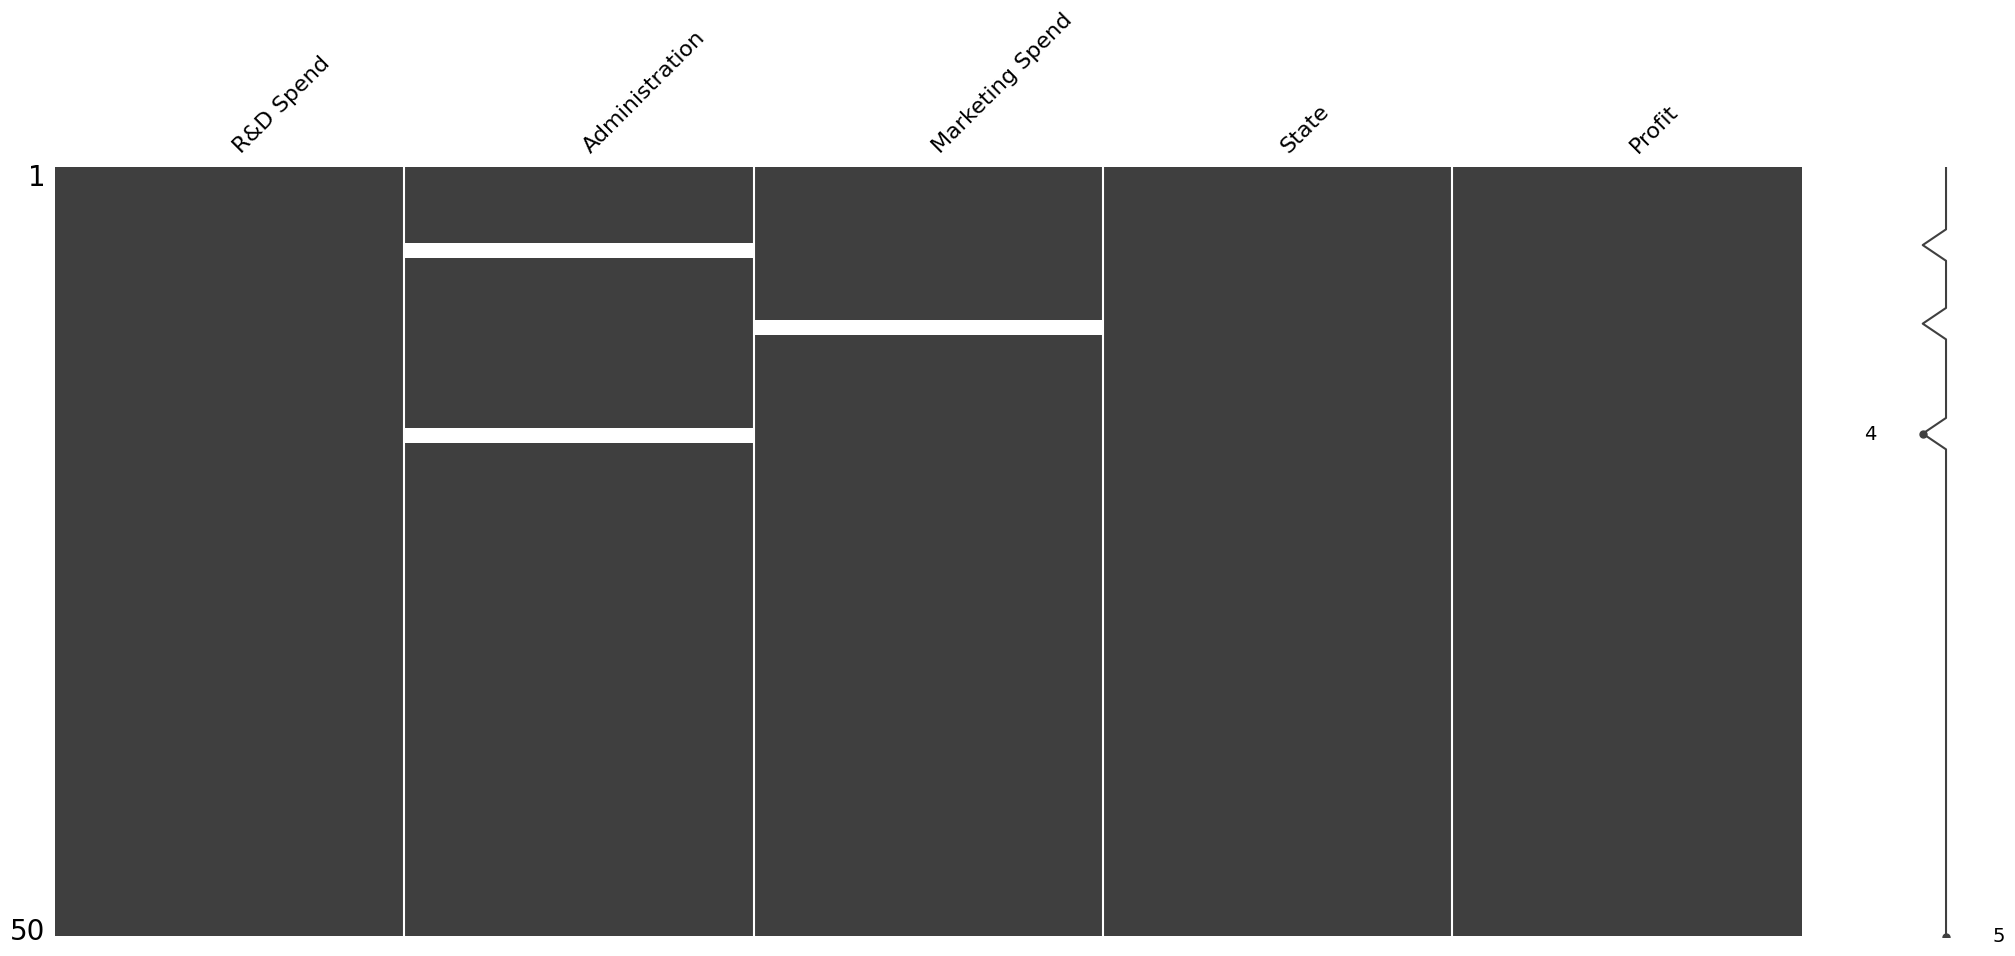

In [3]:
print("Missing Values in Each Column:\n", df.isnull().sum())  
msno.matrix(df);

### 2. Imputation of Missing Values
To ensure the dataset is complete, missing values in the 'Administration' and 'Marketing Spend' columns are filled with their respective medians.   
This approach preserves the data distribution while addressing gaps in the dataset.

In [4]:
# Fill missing values in the 'Administration' column with its median  
df['Administration'] = df['Administration'].fillna(df['Administration'].median())
df['Marketing Spend'] = df['Marketing Spend'].fillna(df['Marketing Spend'].median())

print("Missing Values in Each Column:\n", df.isnull().sum()) 
df.head()

Missing Values in Each Column:
 R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,166597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

### 3. Convert Categorical Variables
The 'State' categorical variable is converted into a category data type for better handling during analysis. This step is crucial for preparing the data for encoding.

In [6]:
df['State'] = df['State'].astype('category')

### 4. Encoding Categorical Variables
To enable effective modeling, categorical variables are transformed into numerical format using one-hot encoding.   
This process creates binary columns for each category, allowing the regression model to utilize these features.

In [19]:
# 2. Encoding categorical variables  
df_encoded = pd.get_dummies(df, columns=['State'], dtype=int)
df_encoded.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,166597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


### 5. Change Order of Columns
Rearranging the columns into a logical order improves the readability of the dataset.   
This step ensures that similar attributes are grouped together, making it easier to navigate the data.

In [20]:
column_order = ['R&D Spend', 'Administration', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York', 'Profit']  
df_encoded = df_encoded[column_order]
df_encoded.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York,Profit
0,165349.20,136897.80,471784.10,0,0,1,192261.83
1,166597.70,151377.59,443898.53,1,0,0,191792.06
2,153441.51,101145.55,407934.54,0,1,0,191050.39
3,144372.41,118671.85,383199.62,0,0,1,182901.99
4,142107.34,91391.77,366168.42,0,1,0,166187.94


### 6. Rename Columns for Better Readability
To enhance the clarity of the dataset, specific columns are renamed. This makes it easier to interpret the data without confusion arising from spaces or lengthy names.

In [21]:
df_encoded.rename(columns={'R&D Spend': 'R&D_Spend', 'Marketing Spend': 'Marketing_Spend'}, inplace=True)
df_encoded.head()

,R&D_Spend,Administration,Marketing_Spend,State_California,State_Florida,State_New York,Profit
0,165349.20,136897.80,471784.10,0,0,1,192261.83
1,166597.70,151377.59,443898.53,1,0,0,191792.06
2,153441.51,101145.55,407934.54,0,1,0,191050.39
3,144372.41,118671.85,383199.62,0,0,1,182901.99
4,142107.34,91391.77,366168.42,0,1,0,166187.94


### 7. Outlier Detection and Removal
Outliers can significantly skew the results of data analysis and modeling. This step involves detecting and removing outliers for numerical columns in the dataset using the Interquartile Range (IQR) method. A boxplot is also generated for visualizing the distribution and identifying potential outliers within each relevant column.

In [22]:
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  

# Function to detect and remove outliers for a single column  
def detect_and_remove_outliers(df, column_name, multiplier=1.5):  
    """  
    Detect and remove outliers from a specified column in the DataFrame.  
    
    Parameters:  
    df (pd.DataFrame): The DataFrame from which to remove outliers.  
    column_name (str): The column in which to detect outliers.  
    multiplier (float): The multiplier for the IQR method to define outliers.  

    Returns:  
    pd.DataFrame: DataFrame without outliers.  
    pd.DataFrame: Outliers detected in the specified column.  
    """  
    # Calculate quantiles for outlier detection  
    Q1 = df[column_name].quantile(0.25)  
    Q3 = df[column_name].quantile(0.75)  
    IQR = Q3 - Q1  
    
    # Calculate lower and upper bounds for outlier detection  
    lower_bound = Q1 - (multiplier * IQR)   
    upper_bound = Q3 + (multiplier * IQR)  

    # Detect outliers  
    outliers = df[~df[column_name].between(lower_bound, upper_bound)]  

    # Remove outliers from DataFrame  
    df_no_outliers = df[df[column_name].between(lower_bound, upper_bound)]  

    # Create boxplot to visualize outliers  
    plt.figure(figsize=(8, 6))  
    plt.boxplot(df[column_name], vert=False, patch_artist=True, showmeans=True)  
    plt.xlabel(column_name)  
    plt.title(f'Boxplot of {column_name}')  
    plt.show()  

    return df_no_outliers, outliers

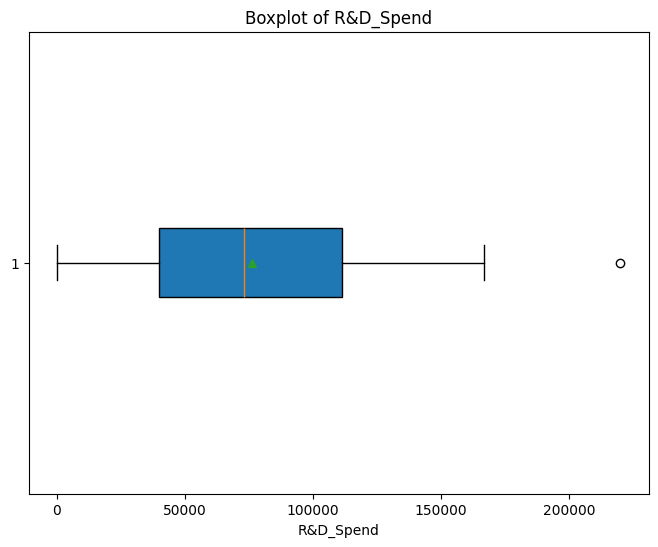

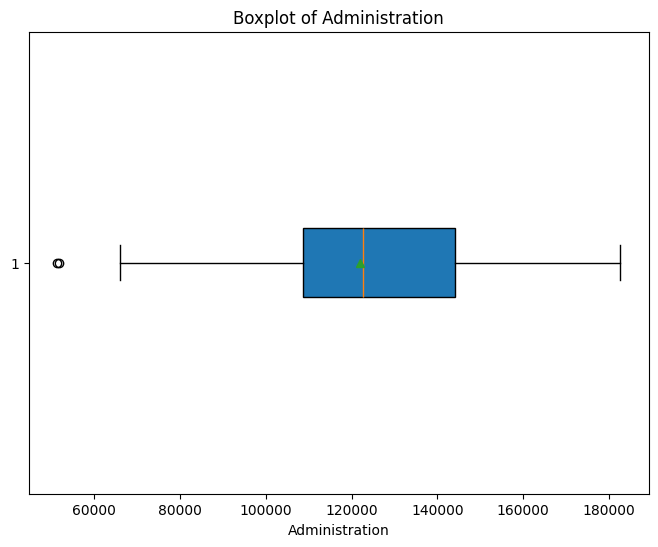

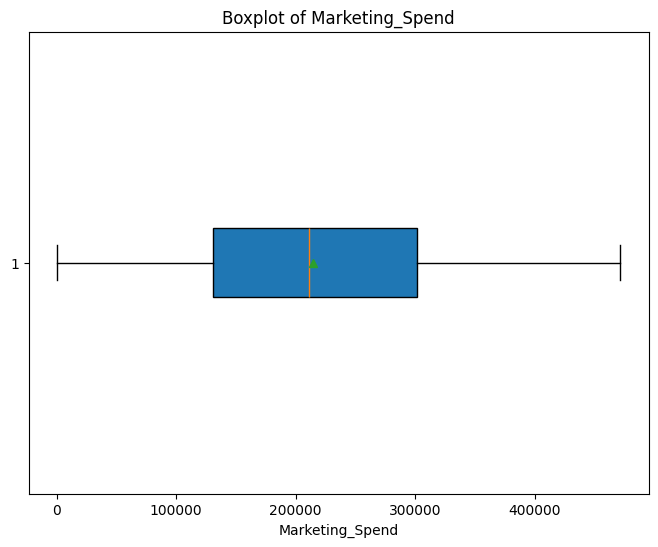

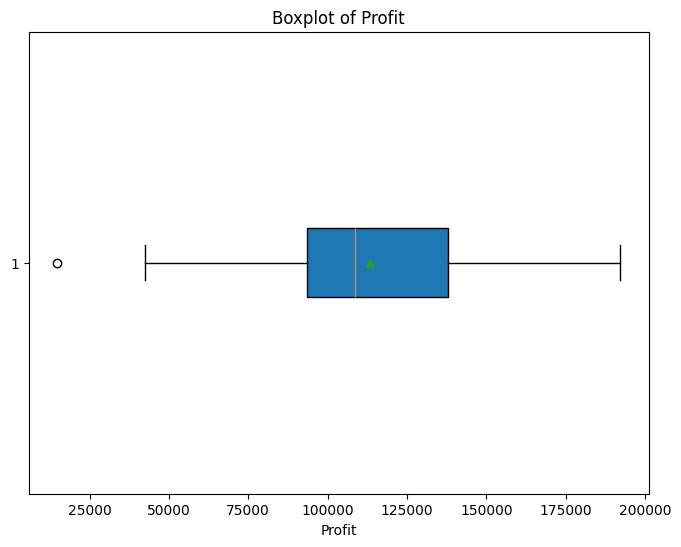

In [23]:
# Initialize list for outliers data  
all_outliers = []  

# Apply the function to each relevant column, excluding binary columns  
for column_name in df_encoded.columns:  
    if df_encoded[column_name].nunique() > 2:  # Exclude binary or categorical columns  
        df_encoded, outliers = detect_and_remove_outliers(df_encoded, column_name)  
        all_outliers.append((column_name, outliers))  

In [24]:
# Optionally, print or save outlier information  
for column_name, outliers in all_outliers:  
    if not outliers.empty:  
        print(f"Outliers detected in {column_name}:\n{outliers}")

Outliers detected in R&D_Spend:
    R&D_Spend  Administration  Marketing_Spend  State_California  \
11   220000.6        91790.61        249744.55                 1   

    State_Florida  State_New York    Profit  
11              0               0  144259.4  
Outliers detected in Administration:
    R&D_Spend  Administration  Marketing_Spend  State_California  \
37   44069.95        51283.14        197029.42                 1   
48     542.05        51743.15             0.00                 0   

    State_Florida  State_New York    Profit  
37              0               0  89949.14  
48              0               1  35673.41  
Outliers detected in Profit:
    R&D_Spend  Administration  Marketing_Spend  State_California  \
49        0.0        116983.8         45173.06                 1   

    State_Florida  State_New York   Profit  
49              0               0  14681.4  


In [25]:
# Print the final dataframe without outliers  
print("Final DataFrame without outliers:")  
df_encoded.head()  

Final DataFrame without outliers:


,R&D_Spend,Administration,Marketing_Spend,State_California,State_Florida,State_New York,Profit
0,165349.20,136897.80,471784.10,0,0,1,192261.83
1,166597.70,151377.59,443898.53,1,0,0,191792.06
2,153441.51,101145.55,407934.54,0,1,0,191050.39
3,144372.41,118671.85,383199.62,0,0,1,182901.99
4,142107.34,91391.77,366168.42,0,1,0,166187.94


## Feature Analysis and Selection Process for Predicting Profit

### 1. Correlation Analysis on Non-Binary Columns
This section identifies non-binary columns and computes the correlation matrix.

In [29]:
# Identify non-binary columns (columns with more than 2 unique values)  
non_binary_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() > 2]  

# Calculate the correlation matrix   
corr_matrix = df_encoded[non_binary_cols].corr().abs().sort_values(by='Profit', ascending=False)
corr_matrix

,R&D_Spend,Administration,Marketing_Spend,Profit
Profit,0.979140,0.121229,0.717590,1.000000
R&D_Spend,1.000000,0.183530,0.692837,0.979140
Marketing_Spend,0.692837,0.151462,1.000000,0.717590
Administration,0.183530,1.000000,0.151462,0.121229


### 2. Visualize the Correlation Heatmap
This section visualizes the correlation matrix using a heatmap for better interpretation.

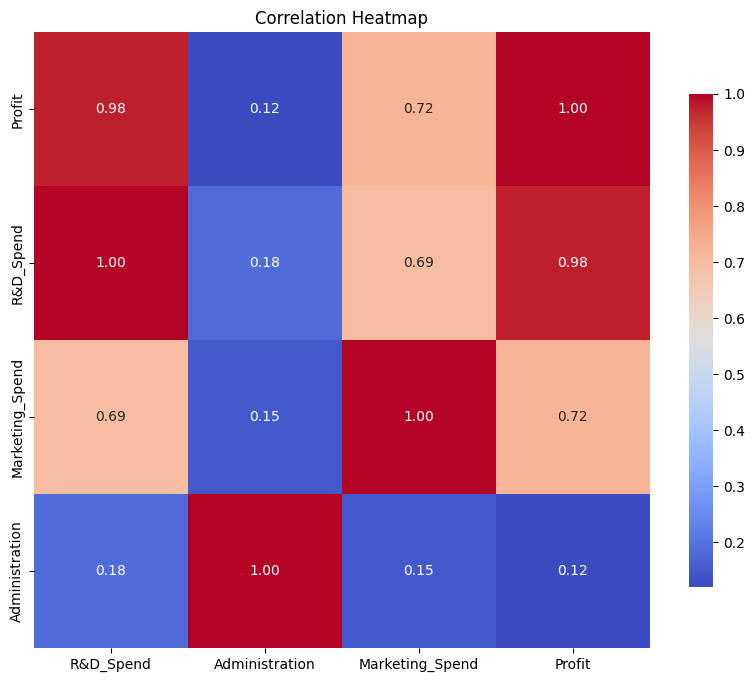

In [30]:
import seaborn as sns  
import matplotlib.pyplot as plt  

# Set the size of the heatmap  
plt.figure(figsize=(10, 8))  

# Create a heatmap to visualize the correlations  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  
plt.title('Correlation Heatmap')  
plt.show()

### 3. Interpret Correlations

**High Correlation**:
- `R&D_Spend` has a very high correlation with Profit (0.979), suggesting it is a strong predictor.
- `Marketing_Spend` also shows a notable positive correlation with Profit (0.718).

**Low Correlation**:  
- `Administration` has a low correlation with Profit (0.121), indicating it may not be a significant predictor of profit.

In [33]:
# Displaying correlations with 'Profit'  
profit_correlations = corr_matrix['Profit'].sort_values(ascending=False)  
print("Correlations with Profit:")  
print(profit_correlations)  

# Optional: Identify features with high correlation (> 0.5)  
high_corr_features = profit_correlations[profit_correlations.abs() > 0.5]  
print("\nFeatures with high correlation to Profit:")  
print(high_corr_features)

Correlations with Profit:
Profit             1.000000
R&D_Spend          0.979140
Marketing_Spend    0.717590
Administration     0.121229
Name: Profit, dtype: float64

Features with high correlation to Profit:
Profit             1.00000
R&D_Spend          0.97914
Marketing_Spend    0.71759
Name: Profit, dtype: float64


### 4. Feature Selection
This section selects features for modeling based on the correlation analysis, typically by choosing those with significant correlation with the target variable.

In [38]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
 
# Drop the 'Administration' feature from the DataFrame  
# Using errors='ignore' to avoid errors if the column doesn't exist  
df_encoded = df_encoded.drop(columns=['Administration'], errors='ignore')  

In [40]:
df_encoded.head()

,R&D_Spend,Marketing_Spend,State_California,State_Florida,State_New York,Profit
0,165349.20,471784.10,0,0,1,192261.83
1,166597.70,443898.53,1,0,0,191792.06
2,153441.51,407934.54,0,1,0,191050.39
3,144372.41,383199.62,0,0,1,182901.99
4,142107.34,366168.42,0,1,0,166187.94


In [41]:
# Split the dataset into features (X) and target (y)  
X = df_encoded.iloc[:, :-1].values  
y = df_encoded.iloc[:, -1].values    

# Train-test split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)  
print("Train shape:", X_train.shape, y_train.shape)  
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (36, 5) (36,)
Test shape: (10, 5) (10,)


## Model Training 

In [42]:
print("Training the Linear Regression model...")  
model = LinearRegression()  # Initialize the model  
model.fit(X_train, y_train)  # Fit the model to the training data 

Training the Linear Regression model...


LinearRegression()

## 2. Model Parameters  
Display model intercept and coefficients  

In [43]:
print("Model Intercept:", model.intercept_)  
print("Model Coefficients:", model.coef_)  

Model Intercept: 51610.98294118439
Model Coefficients: [ 7.39765592e-01  3.11190673e-02 -1.65620143e+02  4.14135104e+02
 -2.48514961e+02]


In [17]:
# Train the Linear Regression model  
model = LinearRegression()  
model.fit(X_train, y_train)  

# Display model intercept and coefficients  
print("Model Intercept:", model.intercept_)  
print("Model Coefficients:", model.coef_)  

Model Intercept: 60413.11362201432
Model Coefficients: [ 7.68736475e-01 -7.20222205e-02  2.15327626e-02  2.13032051e+01
  4.24060022e+02 -4.45363227e+02]


##  Predictions and Model Evaluation  

In [ ]:
# Predict values for the test set  
y_pred = model.predict(X_test)  

# Evaluate the model using Mean Squared Error (MSE) and R² Score  
mse = mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred) 

print(f"Mean Squared Error: {mse:.2f}")  
print(f"Mean Absolute Error: {mae:.2f}") 
print(f"R² Score: {r2:.2f}") 

Mean Squared Error: 69683586.97
Mean Absolute Error: 7078.76
R² Score: 0.96


## Visualization (Optional)  

Visualizing predictions vs actual outcomes...


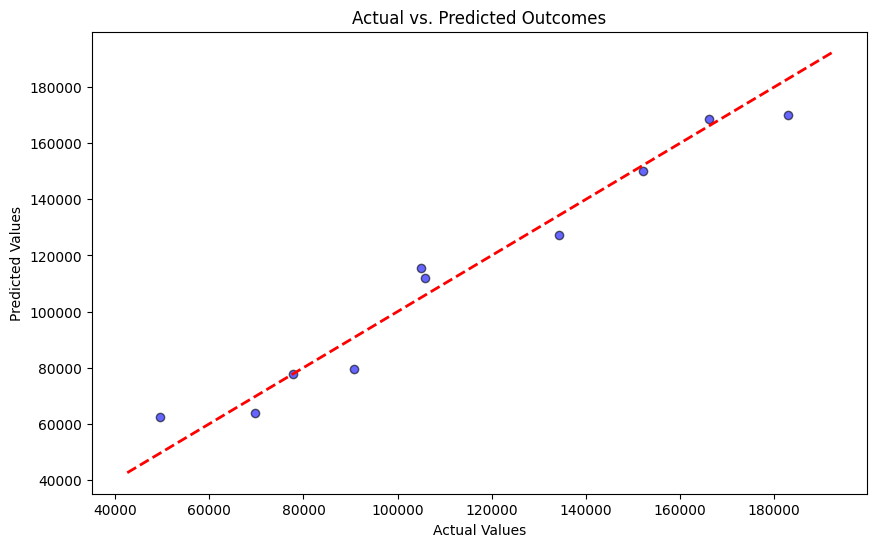

In [49]:
print("Visualizing predictions vs actual outcomes...")  
plt.figure(figsize=(10, 6))  
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.6)  # Scatter plot of actual vs predicted  
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line for reference  
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')  
plt.title('Actual vs. Predicted Outcomes')  
plt.show()  